In [1]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

import seaborn as sns


from tqdm import tqdm
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pytorch_metric_learning import losses
from pytorch_metric_learning import miners
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2, shufflenet_v2_x1_5
from sklearn.metrics import silhouette_score, silhouette_samples


%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


plt.rcParams['font.family'] = 'Liberation Serif'

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

In [2]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [3]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [4]:
#mobi = mobilenet_v2(weights = 'IMAGENET1K_V1')

In [4]:
Shufflenet = shufflenet_v2_x1_5(weights = 'IMAGENET1K_V1')


Shufflenet.fc = nn.Linear(1024, 256, bias = True)

Shufflenet = Shufflenet.to(device)
# Efficient_b0 = Efficient_b0.to(device)

In [6]:
# Shufflenet = shufflenet_v2_x1_5(weights = 'IMAGENET1K_V1')

# total_count = 0
# frozen_count = 0
# for name, param in Shufflenet.named_parameters():
#     total_count += 1
#     for block in ['stage4', 'conv5','fc']:
#         if name.startswith(block):
#             param.requires_grad = True
#             break
#         else:
#             param.requires_grad = False
#     print(f'{name} grad {param.requires_grad}')
# print(total_count)
# print(frozen_count)


In [7]:
## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)
optimizer = torch.optim.AdamW(Shufflenet.parameters(), lr=1e-4)
miner_func = miners.MultiSimilarityMiner(epsilon=0.01)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

f = open("./Shufflenet.txt",'w')
f.close()

for epoch in range(Epochs):
    with open("./Shufflenet.txt", "a") as f:
        train_loss = lib.metric_train(train_loader, Shufflenet, loss_fn, optimizer, miner_func)
        valid_loss = lib.metric_validation(valid_loader, Shufflenet, loss_fn, miner_func)
        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Shufflenet.state_dict(),
                    'optimizer' : optimizer.state_dict()}, '../model_weight/Deep_metric/Shufflenet.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break
            


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


Epoch 0 : Train Loss = 5.4286, Valid Loss = 4.1280
Epoch 0 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


Epoch 1 : Train Loss = 4.0641, Valid Loss = 3.6528
Epoch 1 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.05it/s]


Epoch 2 : Train Loss = 3.6439, Valid Loss = 3.4211
Epoch 2 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


Epoch 3 : Train Loss = 3.4359, Valid Loss = 3.2231
Epoch 3 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.09it/s]


Epoch 4 : Train Loss = 3.3628, Valid Loss = 3.0469
Epoch 4 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


Epoch 5 : Train Loss = 3.1173, Valid Loss = 2.9042
Epoch 5 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.86it/s]


Epoch 6 : Train Loss = 3.0354, Valid Loss = 2.9730


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]


Epoch 7 : Train Loss = 2.9122, Valid Loss = 2.7623
Epoch 7 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch 8 : Train Loss = 2.8118, Valid Loss = 2.6593
Epoch 8 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


Epoch 9 : Train Loss = 2.7243, Valid Loss = 2.6678


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.00it/s]


Epoch 10 : Train Loss = 2.6943, Valid Loss = 2.4915
Epoch 10 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Epoch 11 : Train Loss = 2.6411, Valid Loss = 2.3249
Epoch 11 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


Epoch 12 : Train Loss = 2.4668, Valid Loss = 2.3546


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.46it/s]


Epoch 13 : Train Loss = 2.2763, Valid Loss = 2.3711


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


Epoch 14 : Train Loss = 2.2444, Valid Loss = 2.2663
Epoch 14 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.09it/s]


Epoch 15 : Train Loss = 2.2762, Valid Loss = 2.3991


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


Epoch 16 : Train Loss = 2.1473, Valid Loss = 2.4194


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.93it/s]


Epoch 17 : Train Loss = 2.0614, Valid Loss = 2.3736


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


Epoch 18 : Train Loss = 2.0757, Valid Loss = 2.3275


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 19 : Train Loss = 1.7137, Valid Loss = 2.5539


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch 20 : Train Loss = 1.8530, Valid Loss = 2.2616
Epoch 20 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch 21 : Train Loss = 1.7462, Valid Loss = 2.2594
Epoch 21 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 22 : Train Loss = 1.7719, Valid Loss = 2.2174
Epoch 22 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.54it/s]


Epoch 23 : Train Loss = 1.5422, Valid Loss = 2.2561


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 24 : Train Loss = 1.5426, Valid Loss = 2.3218


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 25 : Train Loss = 1.4992, Valid Loss = 2.4262


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 26 : Train Loss = 1.2928, Valid Loss = 2.6130


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


Epoch 27 : Train Loss = 1.3164, Valid Loss = 2.2895


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 28 : Train Loss = 1.1960, Valid Loss = 2.3881


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 29 : Train Loss = 0.9035, Valid Loss = 2.1963
Epoch 29 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch 30 : Train Loss = 1.0777, Valid Loss = 2.2928


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 31 : Train Loss = 1.0243, Valid Loss = 2.5295


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 32 : Train Loss = 0.8270, Valid Loss = 2.4353


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 33 : Train Loss = 0.8546, Valid Loss = 2.3981


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.67it/s]


Epoch 34 : Train Loss = 0.7268, Valid Loss = 2.4257


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch 35 : Train Loss = 0.6364, Valid Loss = 2.2520


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch 36 : Train Loss = 0.6344, Valid Loss = 2.5293


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 37 : Train Loss = 0.5491, Valid Loss = 2.3704


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.57it/s]


Epoch 38 : Train Loss = 0.5423, Valid Loss = 2.2489


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.47it/s]

Epoch 39 : Train Loss = 0.4895, Valid Loss = 2.2798
early stopping


## Deep Metric Model Load 및 시각화

In [5]:
Shufflenet = shufflenet_v2_x1_5(weights = 'IMAGENET1K_V1')
Shufflenet.fc = nn.Linear(1024, 256, bias = True)

checkpoint = torch.load('../model_weight/Deep_metric/Shufflenet.pth')

Shufflenet.load_state_dict(checkpoint['model'])
Shufflenet = Shufflenet.to(device)


In [6]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)


In [7]:
embeddings = []
labels = []

with torch.no_grad():
    Shufflenet.eval()
    for data, label in tqdm(total_loader_t):
        embedding = Shufflenet(data.to(device))
        embeddings.append(embedding) ## embeddings = (n, emb)
        labels.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:02<00:00, 74.47it/s]


0.45851826667785645

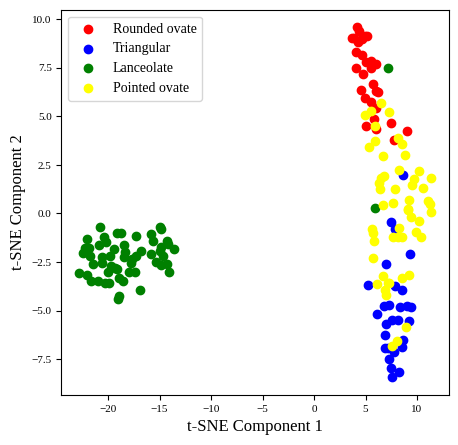

In [8]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= labels
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

score = silhouette_score(X_tsne, labels)
score

In [9]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.624351
1    0.425105
2    0.775393
3    0.038663
Name: sil_coeffi, dtype: float32

In [ ]:
v

label
0    0.475835
1    0.429305
2    0.765642
3    0.167483

## 2-stage Classifier 학습

In [13]:
## 2-stage Classifier Training

class MyNeural(nn.Module):
    def __init__(self, model):
        super(MyNeural, self).__init__()

        self.mother = model

        for param in self.mother.parameters():
            param.requires_grad = False    
        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(64, 4, bias = True)
        )

    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return embedding, x



In [14]:
Shufflenet_with_classifier = MyNeural(Shufflenet).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Shufflenet_with_classifier.parameters(), lr=1e-4)

save_model_name = 'Shufflenet_with_classifier'

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

f = open(f"./loss_log/{save_model_name}.txt",'w')
f.close()


for epoch in range(Epochs):
    with open(f"./loss_log/{save_model_name}.txt",'a') as f:
        train_loss, train_correct = lib.classifier_train(train_loader, Shufflenet_with_classifier, loss_fn, optimizer)
        valid_loss, valid_correct = lib.classifier_validation(valid_loader, Shufflenet_with_classifier, loss_fn)

        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Shufflenet_with_classifier.state_dict(),
                    'optimizer' : optimizer.state_dict()}, f'../model_weight/Deep_metric/{save_model_name}.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break
        

Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 0 : Train Loss = 1.3587, Train Correct: 0.33674339300937767 Valid Loss = 1.3204, Valid Correct = 0.4166666666666667
Epoch 0 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 1 : Train Loss = 1.2745, Train Correct: 0.5575447570332481 Valid Loss = 1.2359, Valid Correct = 0.6309523809523809
Epoch 1 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch 2 : Train Loss = 1.1869, Train Correct: 0.6547314578005116 Valid Loss = 1.1454, Valid Correct = 0.6458333333333334
Epoch 2 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 3 : Train Loss = 1.0911, Train Correct: 0.6658141517476556 Valid Loss = 1.0432, Valid Correct = 0.6517857142857143
Epoch 3 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.47it/s]


Epoch 4 : Train Loss = 0.9854, Train Correct: 0.6811594202898551 Valid Loss = 0.9544, Valid Correct = 0.6755952380952381
Epoch 4 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


Epoch 5 : Train Loss = 0.8859, Train Correct: 0.7212276214833759 Valid Loss = 0.8585, Valid Correct = 0.7023809523809523
Epoch 5 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch 6 : Train Loss = 0.7924, Train Correct: 0.7485080988917306 Valid Loss = 0.7855, Valid Correct = 0.7440476190476191
Epoch 6 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch 7 : Train Loss = 0.7259, Train Correct: 0.7962489343563512 Valid Loss = 0.7229, Valid Correct = 0.7708333333333334
Epoch 7 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


Epoch 8 : Train Loss = 0.6449, Train Correct: 0.8482523444160273 Valid Loss = 0.6450, Valid Correct = 0.8184523809523809
Epoch 8 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.50it/s]


Epoch 9 : Train Loss = 0.5694, Train Correct: 0.876385336743393 Valid Loss = 0.6052, Valid Correct = 0.8363095238095238
Epoch 9 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.60it/s]


Epoch 10 : Train Loss = 0.5187, Train Correct: 0.8942881500426257 Valid Loss = 0.5476, Valid Correct = 0.8541666666666666
Epoch 10 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 11 : Train Loss = 0.4721, Train Correct: 0.9173060528559249 Valid Loss = 0.4963, Valid Correct = 0.8779761904761905
Epoch 11 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 12 : Train Loss = 0.4154, Train Correct: 0.9360613810741688 Valid Loss = 0.4775, Valid Correct = 0.8779761904761905
Epoch 12 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 13 : Train Loss = 0.4032, Train Correct: 0.927536231884058 Valid Loss = 0.4320, Valid Correct = 0.8720238095238095
Epoch 13 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 14 : Train Loss = 0.3500, Train Correct: 0.9462915601023018 Valid Loss = 0.4108, Valid Correct = 0.8809523809523809
Epoch 14 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.50it/s]


Epoch 15 : Train Loss = 0.3225, Train Correct: 0.947996589940324 Valid Loss = 0.3904, Valid Correct = 0.8720238095238095
Epoch 15 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch 16 : Train Loss = 0.3007, Train Correct: 0.9471440750213129 Valid Loss = 0.3812, Valid Correct = 0.8928571428571429
Epoch 16 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 17 : Train Loss = 0.2831, Train Correct: 0.9522591645353794 Valid Loss = 0.3708, Valid Correct = 0.8809523809523809
Epoch 17 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 18 : Train Loss = 0.2627, Train Correct: 0.9573742540494459 Valid Loss = 0.3617, Valid Correct = 0.8839285714285714
Epoch 18 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 19 : Train Loss = 0.2407, Train Correct: 0.9616368286445013 Valid Loss = 0.3361, Valid Correct = 0.875
Epoch 19 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 20 : Train Loss = 0.2213, Train Correct: 0.9556692242114238 Valid Loss = 0.3277, Valid Correct = 0.8809523809523809
Epoch 20 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch 21 : Train Loss = 0.2101, Train Correct: 0.9607843137254902 Valid Loss = 0.3339, Valid Correct = 0.8839285714285714


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


Epoch 22 : Train Loss = 0.2228, Train Correct: 0.9556692242114238 Valid Loss = 0.3251, Valid Correct = 0.8839285714285714
Epoch 22 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.60it/s]


Epoch 23 : Train Loss = 0.2153, Train Correct: 0.9548167092924126 Valid Loss = 0.3212, Valid Correct = 0.8958333333333334
Epoch 23 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.54it/s]


Epoch 24 : Train Loss = 0.2071, Train Correct: 0.9582267689684569 Valid Loss = 0.3134, Valid Correct = 0.8898809523809523
Epoch 24 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


Epoch 25 : Train Loss = 0.1876, Train Correct: 0.9641943734015346 Valid Loss = 0.3052, Valid Correct = 0.8839285714285714
Epoch 25 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 26 : Train Loss = 0.1788, Train Correct: 0.9573742540494459 Valid Loss = 0.3171, Valid Correct = 0.8869047619047619


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 27 : Train Loss = 0.1722, Train Correct: 0.9599317988064792 Valid Loss = 0.3227, Valid Correct = 0.8869047619047619


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 28 : Train Loss = 0.1604, Train Correct: 0.9676044330775788 Valid Loss = 0.3055, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 29 : Train Loss = 0.1577, Train Correct: 0.9616368286445013 Valid Loss = 0.2976, Valid Correct = 0.8898809523809523
Epoch 29 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.65it/s]


Epoch 30 : Train Loss = 0.1695, Train Correct: 0.9607843137254902 Valid Loss = 0.3073, Valid Correct = 0.8928571428571429


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 31 : Train Loss = 0.1716, Train Correct: 0.959079283887468 Valid Loss = 0.3014, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


Epoch 32 : Train Loss = 0.1559, Train Correct: 0.9582267689684569 Valid Loss = 0.3001, Valid Correct = 0.8928571428571429


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 33 : Train Loss = 0.1462, Train Correct: 0.9548167092924126 Valid Loss = 0.3095, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch 34 : Train Loss = 0.1407, Train Correct: 0.9573742540494459 Valid Loss = 0.3085, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch 35 : Train Loss = 0.1449, Train Correct: 0.9582267689684569 Valid Loss = 0.3215, Valid Correct = 0.8779761904761905


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 36 : Train Loss = 0.1444, Train Correct: 0.9548167092924126 Valid Loss = 0.3015, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch 37 : Train Loss = 0.1474, Train Correct: 0.9548167092924126 Valid Loss = 0.3065, Valid Correct = 0.8869047619047619


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 38 : Train Loss = 0.1360, Train Correct: 0.9633418584825234 Valid Loss = 0.3244, Valid Correct = 0.8839285714285714


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]

Epoch 39 : Train Loss = 0.1361, Train Correct: 0.9565217391304348 Valid Loss = 0.3143, Valid Correct = 0.8779761904761905
early stopping


In [45]:
checkpoint = torch.load('../model_weight/Deep_metric/Shufflenet_with_classifier.pth')

Shufflenet_with_classifier.load_state_dict(checkpoint['model'])

valid_loss, valid_correct = lib.classifier_validation(total_loader_v, Shufflenet_with_classifier, loss_fn)
print(valid_correct)

Valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:04<00:00, 75.52it/s]

0.8898809523809523


In [66]:
pred_acc = []
real_acc = []


with torch.no_grad():
    Shufflenet_with_classifier.eval()
    for data, labels in tqdm(total_loader_v):
    
        _, pred = Shufflenet_with_classifier(data.to(device)) ## embeddings = (n, emb)

        pred_acc.append(pred.argmax(1).item())
        real_acc.append(labels.item())
        


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:04<00:00, 79.20it/s]


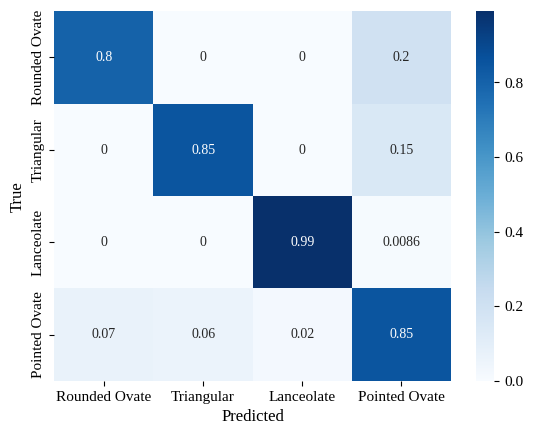

In [67]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 


cm = confusion_matrix(real_acc, pred_acc, normalize = 'true')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [48]:
test['label'].value_counts()

label
2    58
3    53
0    29
1    28
Name: count, dtype: int64

ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 336.

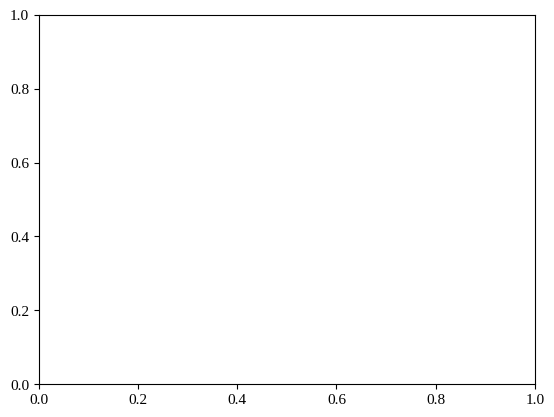

In [49]:
tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(embeddings.detach().cpu())

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= labels, cmap = 'viridis')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(scatter, label='Class')

score = silhouette_score(X_tsne, labels)
score